# Intro tutorial

This document explains how to use the open-source code provided in this repository for calculating self-shading of two-axis tracking solar collectors.

Import necessary packages:

In [1]:
import pandas as pd
# The following libraries are not standard and have to be installed seperately.
# It is recommended to install shapely using conda.
from shapely import geometry
import pvlib
import twoaxistracking

<br>

Now, the first step is to define the location/site for where shading is to be calculated. The location is used to determine the solar position in the next steps.

In [2]:
location = pvlib.location.Location(latitude=54.9788, longitude=12.2666, altitude=100)

<br>

The second step involves generating the discrete time-steps for which shading shall be calculated. Generally the time series should cover one year (preferably not a leap year).

The most **important parameter is the frequency**, e.g., '1min', '15min', '1hr'.

It is also important to set the timezone as this affects the calculation of the solar position. It is recommended to consistently use UTC to avoid mix-ups.

In [3]:
times = pd.date_range(
    start='2019-1-1 00:00',
    end='2019-12-31 23:59',
    freq='15min',  # Edit the frequecy for a shorter or longer time step
    tz='UTC')

Next, the solar position is calculated for all of the time time steps using the [`pvlib-python`](https://pvlib-python.readthedocs.io/en/stable/) package:

In [4]:
df = location.get_solarposition(times)

df.head()  # Show the first 5 lines

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
2019-01-01 00:00:00+00:00,146.937480,146.937480,-56.937480,-56.937480,19.592191,-3.195874
2019-01-01 00:15:00+00:00,146.108706,146.108706,-56.108706,-56.108706,25.665116,-3.200828
2019-01-01 00:30:00+00:00,145.078546,145.078546,-55.078546,-55.078546,31.493630,-3.205782
2019-01-01 00:45:00+00:00,143.866070,143.866070,-53.866070,-53.866070,37.053369,-3.210734
2019-01-01 01:00:00+00:00,142.491152,142.491152,-52.491152,-52.491152,42.334286,-3.215687


## Define the collector aperture geometry

In this step, the solar collector geometry is defined:

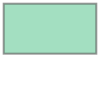

In [5]:
# Change these parameters to suit your particular collector aperture
collector_width = 5.697
collector_height = 3.075

collector_geometry = geometry.box(
    -collector_width/2,  # left x-coordinate
    -collector_height/2,  # bottom y-coordinate
    collector_width/2,  # top y-coordinate
    collector_height/2)  # right x-coordinate

collector_geometry

Similarly, a cirular geometry can be defined as:

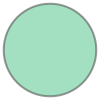

In [6]:
radius = 2
circular_collector = geometry.Point(0, 0).buffer(radius)
circular_collector

<br>

Note, the absolute dimensions do not matter, as the GCR parameter scales the distance between collectors according to the collector area.

<br>

Derive properties from the collector geometry:

In [7]:
collector_area = collector_geometry.area
# Calculate the miminum distance between collectors
# Note, L_min is also referred to as D_min by some authors
L_min = 2 * collector_geometry.hausdorff_distance(geometry.Point(0, 0))

print("Collector area: %2.1f"% collector_area)
print("Collector L_min: %1.2f"% L_min)

Collector area: 17.5
Collector L_min: 6.47


## Field layout definition

Once the collector aperture has been determined, the field layout can be defined. It is important to specify the ground cover ratio (GCR), which is the ratio of the collector are to the ground area.

### Neighbor orderder
The neighbor order determines how many collectors to take into account - for a neighbor order of 1 the immidiate 8 collectors are considered, whereas for a neighbor order of 2, 24 shading collectors are considered. It is recommended to use atleast a neighbor order of 2.

### Standard vs. custom field layouts
It is possible to choose from four different standard field layouts: `square`, `diagonal`, `hexagon_e_w`, and `hexagon_n_s`.

It is also possible to specify a custom layout using the keywords: `aspect ratio`, `offset`, `rotation`, and `gcr`. For a description of the layout parameters, see the paper by [Cumpston and Pye (2014)](https://doi.org/10.1016/j.solener.2014.06.012) or check out the function documentation.

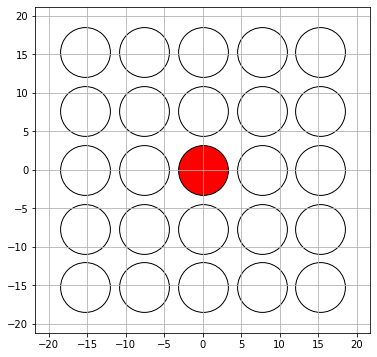

In [15]:
X, Y, tracker_distance, relative_azimuth = \
    twoaxistracking.generate_field_layout(
        gcr=0.3,  # Change this parameter according to your desired density of collectors
        neighbor_order=2,
        layout_type='square',
        L_min=L_min,  # calculated from collector geometry - do not change
        collector_area=collector_area,  # calculated from collector geometry - do not change
        plot=True)

## Calculate shading fraction

Now that the collector geometry and field layout have been defined, it is time to do the actual shading calculations. This step is relatively computational intensive and is mainly affected by the time step, neighbor order, and computational resources available. Typical run times vary between 5 s and 3 min.

In [17]:
%%time
df['shading_fraction'] = \
    df.apply(lambda x: twoaxistracking.shading_fraction(
    solar_azimuth=x['azimuth'],
    solar_elevation=x['elevation'],
    collector_geometry=collector_geometry,
    tracker_distance=tracker_distance,
    relative_azimuth=relative_azimuth,
    L_min=L_min,
    plot=False),
             axis=1)

Wall time: 24.4 s


## Visualize the shading fraction

Plot the shading fraction for one example day:

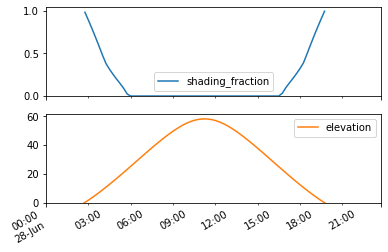

In [18]:
axes = df.loc['2019-06-28':'2019-06-28', ['shading_fraction','elevation']].plot(subplots=True, ylim=[0,None])

<br>

Visualize the average daily shading fraction:

<AxesSubplot:>

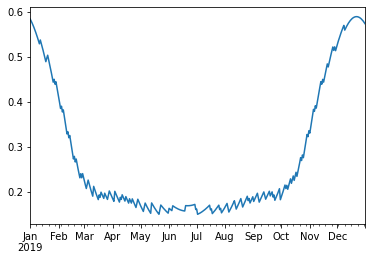

In [19]:
df['shading_fraction'].resample('1d').mean().plot()